<a href="https://colab.research.google.com/github/robomoan/Data_Science_Study/blob/main/Handson_ML/handson_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras

# 3. 분류

## MNIST 생성

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

 * DESCR: 데이터셋을 설명하는 키
 * data: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 키
 * target: 레이블 배열을 담은 키

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


첫번째 샘플 재구조화

In [4]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

print(some_digit_image.shape)

(28, 28)


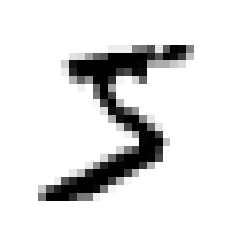

In [5]:
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

In [7]:
# 문자형을 숫자형으로 변환
y = y.astype(np.uint8)

데이터셋을 훈련데이터와 검증 데이터로 나누기

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

5가 맞는지 아닌지 감지하는 5 감지기 훈련, 확률적 경사 하강법 이용

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
# 확률적 경사하강법 클래스 부르기
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 72)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=72)

In [11]:
# 분류기를 가지고 데이터 샘플 분류하기 (실제 5)
sgd_clf.predict([some_digit])

array([ True])

## 성능 측정

### 교차검증을 통한 정확도 측정

`cross_val_score` 함수와 같은 식

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=72, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.95685
0.94185
0.96055


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9377, 0.9689, 0.9596])

In [14]:
# 모든 이미지가 5가 아니라고 분류하는 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

전체 데이터 중 10%가 5이기 때문에 90%의 정확도를 보이는 것은 당연  
불균형한 데이터셋을 다룰 때 정확도를 사용하지 않는 이유

### 오차 행렬

`cross_val_predict()`함수는 k-fold 교차검증을 수행하지만 평가점수를 반환하지 않고 각 테스트 폴드에서 얻은 예측을 반환

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[52882,  1697],
       [  979,  4442]])

1행: 실제로 5가 아님(0), 2행: 실제로 5임(1)  
1열: 5가 아니라고 예측함(0), 2열: 5라고 예측함(1)

* True Negative(5 아닌것을 정확히 예측): 52882
* True Positive(5 인것을 정확히 예측): 4442
* False Positive(5 아닌것을 잘못 예측): 1697
* False Negative(5 인것을 잘못 예측: 979

정밀도(precision): $\frac{TP}{TP + FP}$  
재현율(recall): $\frac{TP}{TP + FN}$

In [18]:
from sklearn.metrics import precision_score, recall_score

# 정확도(precision)
print(precision_score(y_train_5, y_train_pred)) # 4442 / (4442 + 1697)

# 재현율(recall)
print(recall_score(y_train_5, y_train_pred)) # 4442 / (4442 + 979)

0.723570614106532
0.8194060136506179


$F_1$-score: 정밀도와 재현율의 조화평균  
$F_{1} = \frac{2}{\frac{1}{정밀도} + \frac{1}{재현율}}$ 

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7685121107266436

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2724.62726715])

임곗값 조정

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
# 적절한 임곗값 정하기
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  7874.26525882,  -6852.2847618 , -22648.42958088, ...,
        13683.76978851,  -5562.46911999, -10352.3441059 ])

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

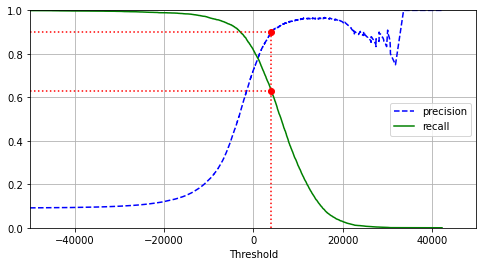

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
  plt.plot(thresholds, recalls[:-1], 'g-', label='recall')
  plt.legend(loc="center right")
  plt.xlabel("Threshold")
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize = (8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:") # 빨간색 세로줄
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:") # 빨간색 위 가로줄
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:") # 빨간색 아래 가로줄
plt.plot([threshold_90_precision], [0.9], "ro") # 빨간색 위 점
plt.plot([threshold_90_precision], [recall_90_precision], "ro") # 빨간색 아래 점
plt.show()

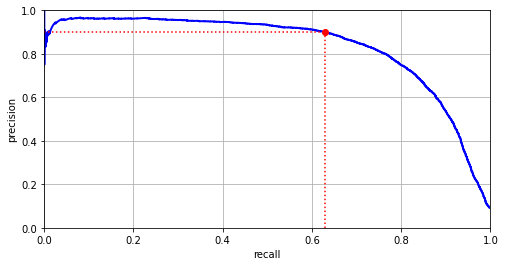

In [26]:
def precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.grid(True)
  plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
precision_vs_recall(precisions, recalls)
plt.plot([0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9
0.6292197011621472


### ROC 곡선

ROC: FPR에 대한 TPR의 그래프  
FPR: 실제 음성들 분모, 음성이지만 양성으로 예측 분자  
TPR: 실제 양성들 분모, 양성으로 맞게 예측 분자(재현율과 같다.)

TNR(특이도): 실제 음성들 분모, 음성을 음성으로 맞게 예측 분자  
FPR = 1- TNR

ROC: 민감도(재현율)에 대한 1-특이도 그래프


In [28]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

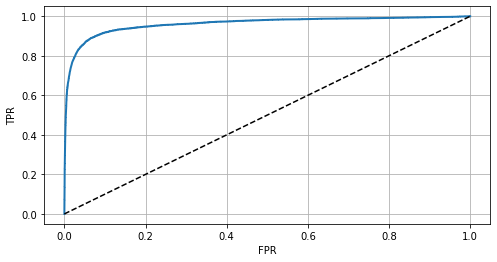

In [29]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0 ,1], [0, 1], "k--")
  plt.xlabel("FPR")
  plt.ylabel("TPR")
  plt.grid(True)

plt.figure(figsize=(8, 4))
plot_roc_curve(fpr, tpr)
plt.show()

AUC: ROC 곡선 아래의 면적  
완벽한 분류기: AUC=1, 완전한 랜덤 분류기: AUC=0.5

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9607487588946978

랜덤 포레스트 방식과 SGD 방식 비교

`predict_proba` 매서드: 샘플당 각 클래스에 속할 확률을 출력

In [31]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=72)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [32]:
y_scores_forest = y_probas_forest[:, 1] # 양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

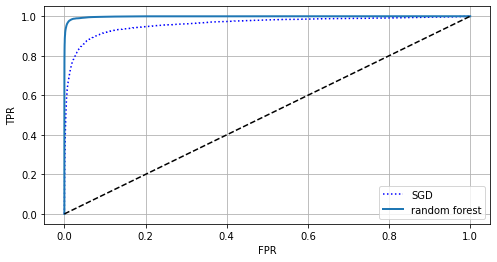

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "random forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983474179858511

## 다중분류

다중분류가 가능한 분류기:  
 * SGD, 랜덤 포레스트, 나이브 베이즈

이진분류만 가능한 분류기:  
 * 로지스틱 회귀, 서포트 벡터 머신

이진분류기 여러개로 다중 클래스 분류:  
 * 각 분류기의 결정 점수 중 가장 높은 것을 클래스로 선택: OvR(one versus the rest)
 * 각 조합마다 이진 분류기를 훈련: OvO(one versus one)

In [35]:
# 서포트 벡터머신: 훈련세트 크기에 민감, OvO 전략 사용
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

클래스별 결정 점수 확인하기

In [36]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

5의 결정 점수가 가장 큼

In [37]:
np.argmax(some_digit_scores)

5

서포트 벡터 머신에서 OvR 사용 강제하기

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

SGD 분류기로 다중분류하기

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
sgd_clf.decision_function([some_digit])

array([[-13524.05548206, -22248.3694136 , -14214.59212626,
          3635.7389925 , -18198.88479283,   4506.52330866,
        -27254.57907316, -14101.83249873,  -9496.88093906,
        -12894.7333353 ]])

5의 점수가 가장 높은 것을 확인할 수 있다.

In [43]:
# SGD 분류기 평가하기: 3-fold 교차검증
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.86795, 0.87385, 0.88135])

입력값 `X_train`의 스케일을 조정하면 분류기의 정확도를 더 높일 수 있다.

In [47]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [49]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([0.90215, 0.89975, 0.90935])

## 에러 분석

In [50]:
# 오차 행렬 만들기
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


array([[5593,    0,   24,    8,    9,   60,   37,    6,  185,    1],
       [   0, 6413,   39,   28,    4,   47,    4,    8,  186,   13],
       [  28,   27, 5274,   96,   71,   28,   71,   40,  313,   10],
       [  23,   18,  117, 5277,    2,  228,   27,   42,  326,   71],
       [  10,   14,   48,   12, 5241,   14,   39,   25,  263,  176],
       [  27,   16,   32,  177,   55, 4557,   75,   17,  401,   64],
       [  31,   17,   47,    2,   41,   99, 5569,    4,  107,    1],
       [  19,   11,   55,   34,   51,   16,    3, 5726,  136,  214],
       [  19,   67,   48,   96,    3,  137,   26,   11, 5396,   48],
       [  25,   22,   31,   71,  121,   42,    1,  181,  276, 5179]])

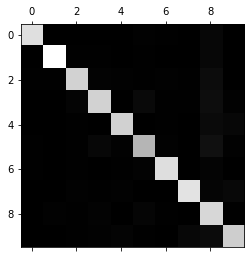

In [51]:
# 오차 행렬을 plot으로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show() 

In [52]:
# 에러 비율로 계산
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

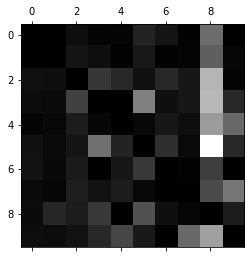

In [53]:
# 주대각선만 0으로 교체
np.fill_diagonal(norm_conf_mx, 0)

# 그래프 그리기
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

8열에 밝은 부분이 많음: 많은 데이터들이 8로 잘못 분류됨  
실제 8은 8로 잘 분류됨  
3과 5가 서로 잘못 분류되는 경우가 있음

In [68]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [57]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

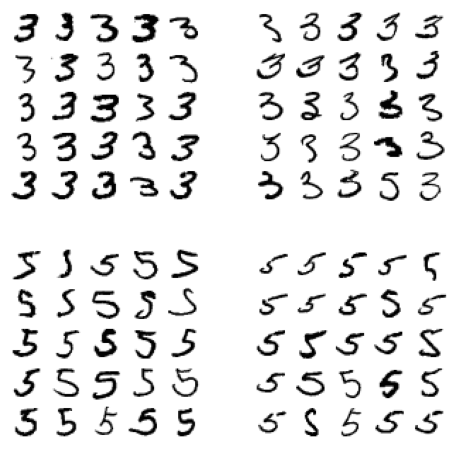

In [60]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

## 다중 레이블 분류

하나의 샘플이 두 개 이상의 클래스에 할당된 경우

In [61]:
from sklearn.neighbors import KNeighborsClassifier

# 두 개의 클래스: 7보다 큰지, 홀수인지
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [62]:
knn_clf.predict([some_digit])

array([[False,  True]])

5는 7보다 크지 않고 홀수이므로 (False, True)

In [63]:
# 다중 레이블 분류기 평가하기: 모든 레이블에 대한 F1-score 의 평균
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

## 다중 출력 분류

한 레이블이 다중 클래스가 될 수 있게 일반화  
클래스 값을 두 개 이상 가질 수 있음

In [66]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

잡음 섞인 이미지를 입력값으로, 깨끗한 이미지를 타깃 이미지로 하는 분류기를 훈련

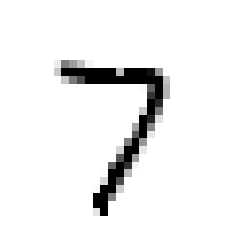

In [70]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)